# International airline passengers: monthly totals in thousands. 
# Jan 49 – Dec 60

<ul>
    <li><a href="#Data-Load">Data Load</a></li>
    <li><a href="#Check-if-data-is-stationary">Check if data is stationary</a></li>
    <li><a href="#Data-preprocessing">Data preprocessing</a></li>
    <li><a href="#ARMA-model">ARMA-model</a></li>
    <li><a href="#Fully-connected-neural-network">Fully connected neural network</a></li>
    <li><a href="#LSTM-recurrent-neural-network">LSTM recurrent neural network</a></li>
    <li><a href="#SVR">SVR</a></li>
    <li><a href="#KNN">KNN</a></li>
    <li><a href="#Random-forest">Random forest</a></li>
    <li><a href="#Summary">Summary</a></li>
</ul>

## Data Load

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = 'data/international-airline-passengers.csv'   

In [3]:
df = pd.read_csv(
    file_path, 
    engine='python',
    index_col=['Month'], 
    parse_dates=['Month'], 
    names=['Month', 'total_passengers'], 
    skipfooter=2, 
    skiprows=1
)
df.shape

(144, 1)

In [4]:
df.head()

,total_passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let's visualize the data to see what it looks like

In [5]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

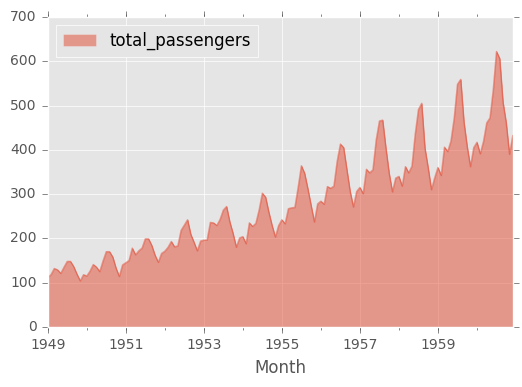

In [6]:
df.total_passengers.plot.area(alpha=0.5, legend=True)

## Check if data is stationary

In [7]:
import statsmodels.api as sm

In [8]:
# apply Dickey-Fuller unit root test
print 'Is stationary: {}'.format(sm.tsa.stattools.adfuller(df['total_passengers'])[1] <= 0.05)

Is stationary: False


In [9]:
res = sm.tsa.seasonal_decompose(df['total_passengers'])

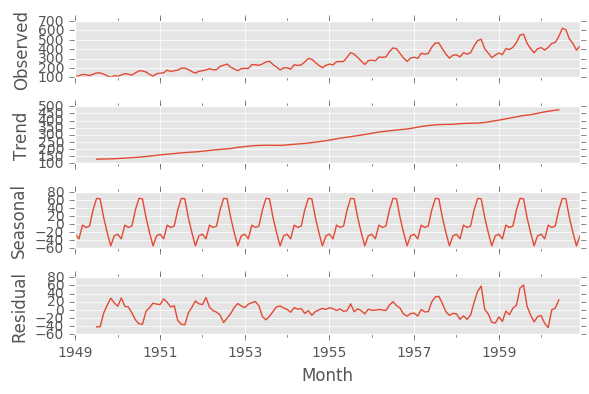

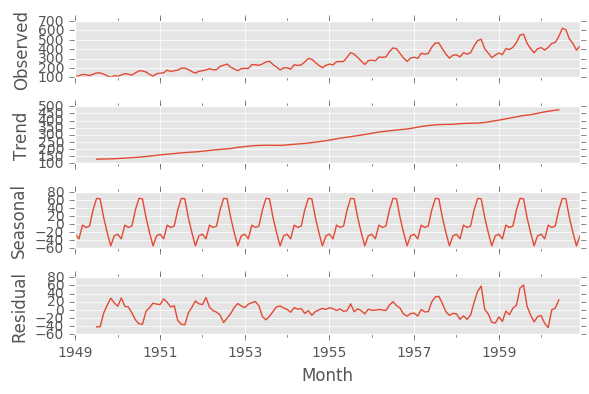

In [10]:
res.plot()

## Data preprocessing

<a href="http://people.duke.edu/~rnau/whatuse.htm">Data transformations and forecasting models: what to use and when</a>

### Stabilize variance
In order to stationarize the data, first of all let's try to stabilize the variance.

In [11]:
from scipy import stats

In [12]:
df['box-cox'], lmbda = stats.boxcox(df.total_passengers)

In [13]:
print 'Optimal box-cox parameter {}'.format(lmbda)
print 'Is stationary: {}'.format(sm.tsa.stattools.adfuller(df['box-cox'])[1] <= 0.05)

Optimal box-cox parameter 0.14802256545
Is stationary: False


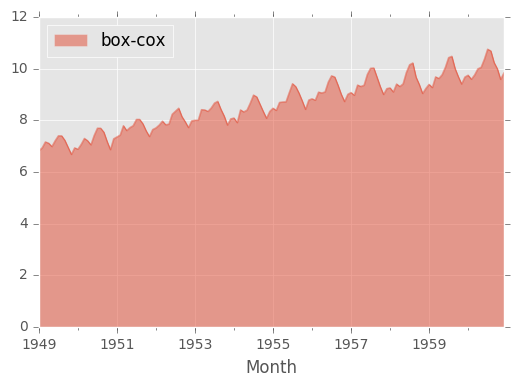

In [14]:
df['box-cox'].plot.area(alpha=0.5, legend=True)

Dickey-Fuller unit root test as well as data visualization indicate that data still not stationary

### Differencing
Variance is stabilized but the trend is still present. Let's apply seasonal differencing to raw data and to transformed data

In [15]:
differencing_order = 12

In [16]:
df['diff12_box-cox'] = df['box-cox'] - df['box-cox'].shift(differencing_order)
print 'is stationary: {}'.format(sm.tsa.stattools.adfuller(df['diff12_box-cox'].dropna())[1] <= 0.05)

is stationary: False


In [17]:
df['diff12'] = df.total_passengers - df.total_passengers.shift(differencing_order)
print 'is stationary: {}'.format(sm.tsa.stattools.adfuller(df['diff12'].dropna())[1] <= 0.05)

is stationary: True


The given time series is stationary only after applying seasonal integrating order 12. Hence we will use it in further computations.

## ARMA-model

### Parameter Selection
The next step is to define the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many <a href="http://people.duke.edu/~rnau/arimrule.htm">rules and best practices</a> about how to select the appropriate parameters of the model.

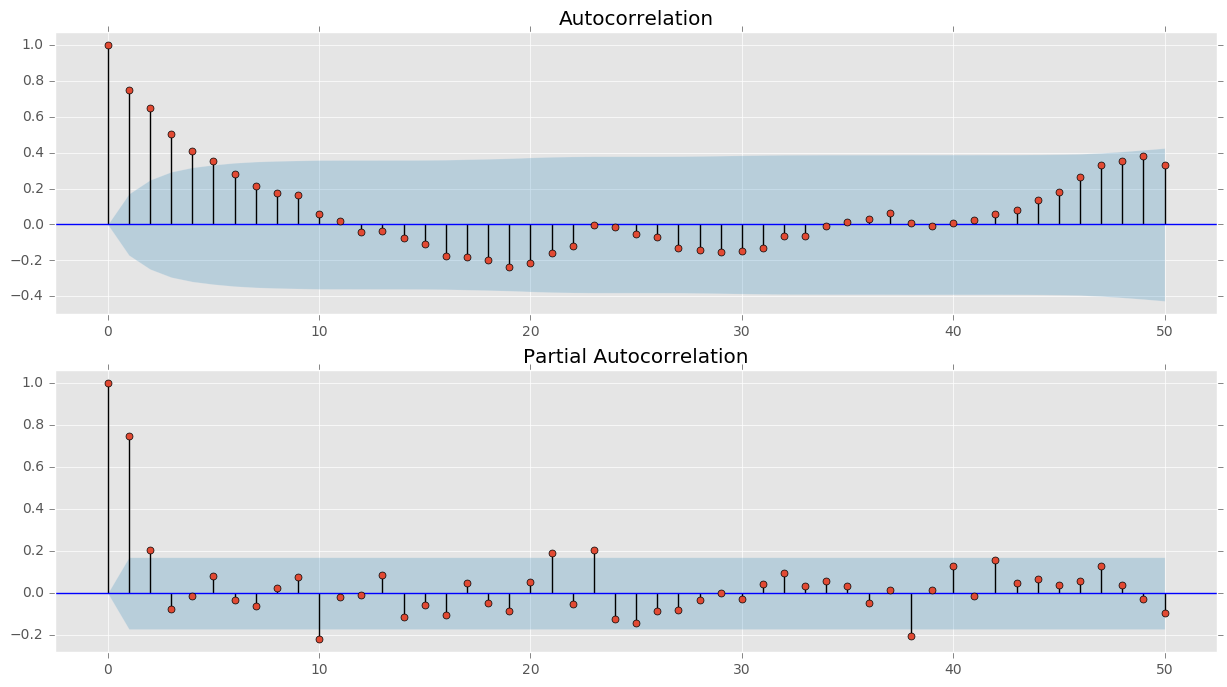

In [18]:
fig, axes = plt.subplots(2,1,figsize=(15,8))

sm.graphics.tsa.plot_acf(df.diff12.dropna().values.squeeze(), lags=50, ax=axes[0])
sm.graphics.tsa.plot_pacf(df.diff12.dropna().values.squeeze(), lags=50, ax=axes[1])

plt.show()

**According to the plots preliminary values of parameters are: **
- p - non-seasonal AR parameter =2 *number of the last non-seasonal lag at which the autocorrelation is significant*
- P - seasonal AR parameter = int(38/12)=3 *number of the last seasonal lag at which the autocorrelation is significant*
- d - non-seasonal differencing order = 0 *it is unnecessary to use non-seasonal differencing because data have become stationary after seasonal differencing*
- D - seasonal differencing order = 1 *annual(12 months = 1 year) differencing*
- q - non-seasonal MA component = 5 *number of the last non-seasonal lag at which the autocorrelation is significant*
- Q - seasonal MA component = 0 *number of the last seasonal lag at which the autocorrelation is significant - there is no seasonal lag with significant autocorrelation*

In [19]:
# select optimal parameters of the model
from itertools import product

ps = range(0, 4)
d=0
qs = range(4, 7)
Ps = range(1, 3)
D=1
Qs = range(0, 2)

# cartesian product of lists of parameters
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

48

### Fit the Model

In [20]:
%%time
import warnings

results = []
best_aic = float("inf") # inf — infinity
warnings.filterwarnings('ignore') # avoid warnings messages

for param in parameters:
    # try/except needed, because model is not trained with some sets of parameters
    try:
        model=sm.tsa.statespace.SARIMAX(
            df.total_passengers, 
            order=(param[0], d, param[1]), # order=(p,d,q)
            seasonal_order=(param[2], D, param[3], differencing_order) # order=(P,D,Q,s)
        ).fit()
    
    # print params set on which model is not trained and go to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save the best model (based on min aic value), aic, params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 7min 18s, sys: 3.02 s, total: 7min 21s
Wall time: 3min 53s


In [21]:
# show best parameters
result_df = pd.DataFrame(results)
result_df.columns = ['(p, q, P, Q)', 'aic']
result_df.sort_values(by='aic', ascending=True).head()

,"(p, q, P, Q)",aic
43,"(3, 5, 2, 1)",1018.615899
47,"(3, 6, 2, 1)",1018.711377
35,"(2, 6, 2, 1)",1022.445000
31,"(2, 5, 2, 1)",1023.012306
19,"(1, 5, 2, 1)",1023.462452


In [22]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   total_passengers   No. Observations:                  144
Model:             SARIMAX(3, 0, 5)x(2, 1, 1, 12)   Log Likelihood                -497.308
Date:                            Fri, 16 Dec 2016   AIC                           1018.616
Time:                                    16:20:38   BIC                           1054.254
Sample:                                01-01-1949   HQIC                          1033.097
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1425      0.000  -1318.310      0.000      -0.143      -0.142
ar.L2          0.1048   3.73e-05   2809.653      0.000       0.105       0.105
ar.L3          0.9294      0.000   3357.922      0.000       0.929       0.930
ma.L1          0.7346      0.007     99.319      0.000       0.720       0.749
ma.L2          0.7117      0.006    115.380      0.000       0.700       0.724
ma.L3         -0.3368      0.005    -68.716      0.000      -0.346      -0.327
ma.L4         -0.1277      0.002    -72.495      0.000      -0.131      -0.124
ma.L5         -0.1623      0.003    -59.761      0.000      -0.168      -0.157
ar.S.L12       0.6089      0.001    558.141      0.000       0.607       0.611
ar.S.L24       0.3843      0.000   1838.935      0.000       0.384       0.385
ma.S.L12      -0.9327      0.006   -165.412      0.000      -0.944      -0.922
sigma2        86.9220    4.8e-05   1.81e+06      0.000      86.922      86.922
===================================================================================
Ljung-Box (Q):                       32.67   Jarque-Bera (JB):                 9.62
Prob(Q):                              0.79   Prob(JB):                         0.01
Heteroskedasticity (H):               2.23   Skew:                             0.30
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients.
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+20. Standard errors may be unstable.
"""

### Check out residuals

Student's t-test: p=0.049613
Dickey—Fuller test: p=0.000000


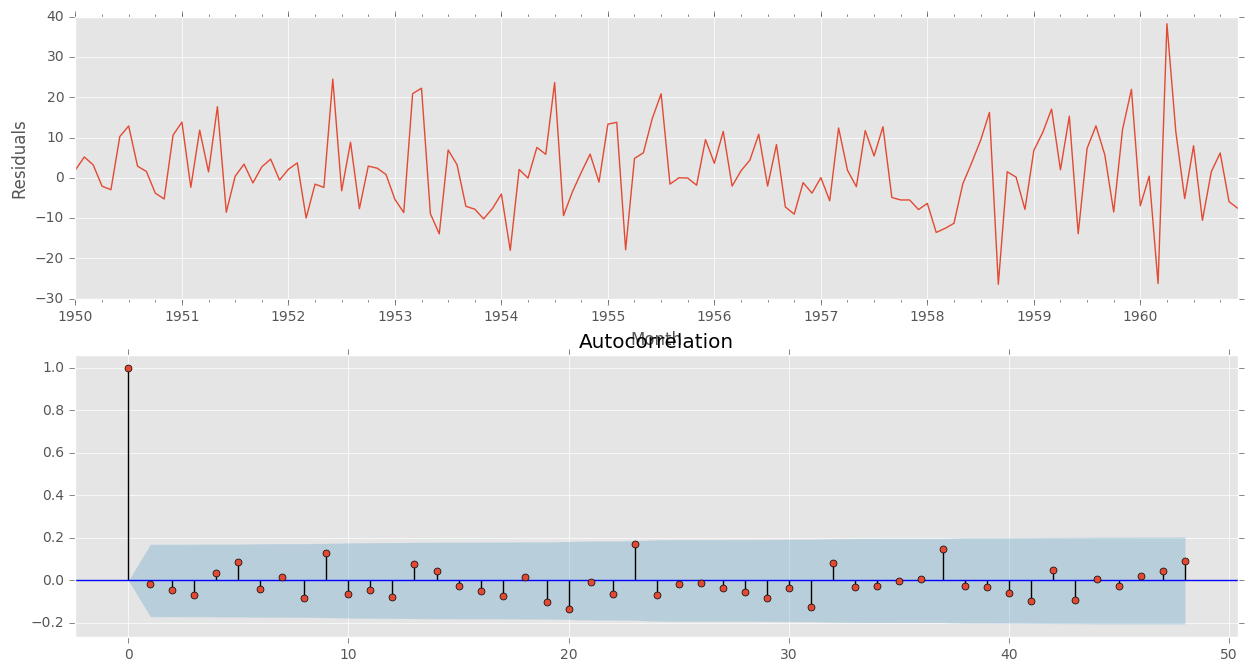

In [23]:
# residuals analysis
plt.figure(figsize=(15,8))

plt.subplot(211)
best_model.resid.ix[differencing_order:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.ix[differencing_order:].values.squeeze(), lags=48, ax=ax)

print "Student's t-test: p={0:.6f}".format(stats.ttest_1samp(best_model.resid.ix[differencing_order:], 0.0)[1])
print "Dickey—Fuller test: p={0:.6f}".format(sm.tsa.stattools.adfuller(best_model.resid.ix[differencing_order:])[1])

### Evaluate Model

In [24]:
def plot_model_prediction(prediction):
    plt.figure(figsize=(15,7))
    df.total_passengers.ix[differencing_order:].plot(color='b', label='Observed', legend=True)
    prediction.ix[differencing_order:].plot(color='r', label='Predicted', legend=True)
    plt.ylabel('Total passengers in thousands')
    plt.show()

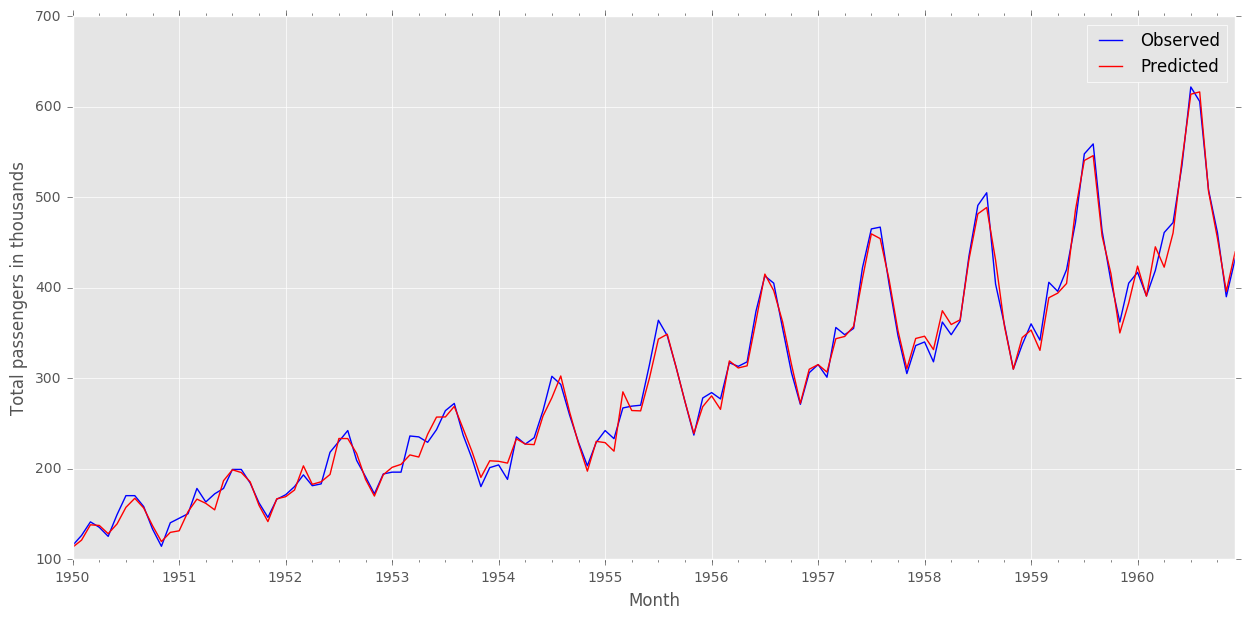

In [26]:
df['arma'] = best_model.predict()
plot_model_prediction(df['arma'])

In [27]:
# Estimate model performance
from sklearn.metrics import mean_squared_error

arma_mse = mean_squared_error(
    df['total_passengers'].ix[differencing_order:], 
    df['arma'].ix[differencing_order:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(arma_mse, np.sqrt(arma_mse))

Model Score: 104.30 MSE (10.21 RMSE)


### Generate Prediction

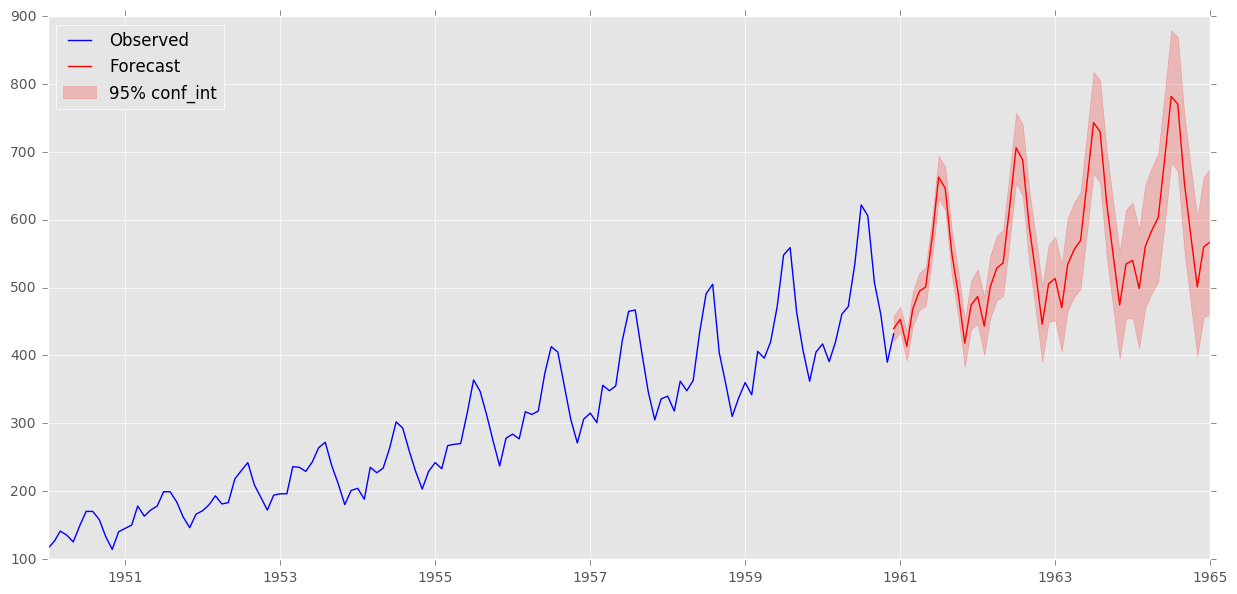

In [28]:
# generate 5-year forecast and 95-% confidence interval
forecast = best_model.get_prediction(start='1960-12-01', end='1965-01-01')
ci_forecast = forecast.conf_int()

plt.figure(figsize=(15,7))
plt.plot(df.total_passengers.ix[differencing_order:], color='b', label='Observed')
plt.plot(forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(ci_forecast.index, ci_forecast.ix[:,0], ci_forecast.ix[:,1], color='r', alpha=0.2, label='95% conf_int')
plt.legend(loc='upper left')

## Fully connected neural network

In [29]:
# reshape into X=t and Y=t+1
def create_dataset(dataset, look_back=1):
    """
    Prepare time series data for predictive analysis
    """
    x, y = [], []
    for i in range(len(dataset)-look_back):
        x.append(dataset[i:(i+look_back)])
        y.append(dataset[i + look_back])
    return np.array(x), np.array(y)

look_back = 4
dataset = df['diff12'].dropna().values.astype('float32')
X, y = create_dataset(dataset, look_back)

X.shape, y.shape

((128, 4), (128,))

### Create Model

In [30]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


In [31]:
epochs = 200
batch_size = 1

seed = 7
np.random.seed(seed)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, y, nb_epoch=epochs, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/200
0s - loss: 2009.4460
Epoch 2/200
0s - loss: 1372.0295
Epoch 3/200
0s - loss: 1349.7242
Epoch 4/200
0s - loss: 1337.3089
Epoch 5/200
0s - loss: 1328.5359
Epoch 6/200
0s - loss: 1321.0491
Epoch 7/200
0s - loss: 1313.8022
Epoch 8/200
0s - loss: 1306.6012
Epoch 9/200
0s - loss: 1299.5319
Epoch 10/200
0s - loss: 1292.4942
Epoch 11/200
0s - loss: 1285.4628
Epoch 12/200
0s - loss: 1278.4586
Epoch 13/200
0s - loss: 1271.4819
Epoch 14/200
0s - loss: 1264.5546
Epoch 15/200
0s - loss: 1257.7043
Epoch 16/200
0s - loss: 1250.8718
Epoch 17/200
0s - loss: 1244.0741
Epoch 18/200
0s - loss: 1237.3481
Epoch 19/200
0s - loss: 1230.6502
Epoch 20/200
0s - loss: 1223.9798
Epoch 21/200
0s - loss: 1217.3374
Epoch 22/200
0s - loss: 1210.7235
Epoch 23/200
0s - loss: 1204.1611
Epoch 24/200
0s - loss: 1197.6013
Epoch 25/200
0s - loss: 1191.0778
Epoch 26/200
0s - loss: 1184.5827
Epoch 27/200
0s - loss: 1178.1194
Epoch 28/200
0s - loss: 1171.6826
Epoch 29/200
0s - loss: 1165.2716
Epoch 30/200
0s - loss:

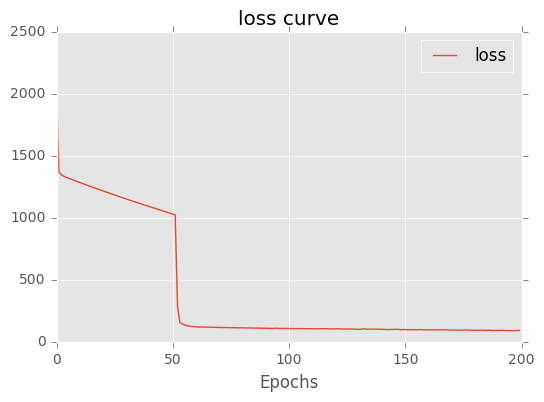

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('loss curve')
plt.show()

### Evaluate Model

In [33]:
# inverse transformation
def inverse_differencing(differenced, original, differencing_order):
    """
    inverse transform differencing values
    """
    # prepend original values in differenced values, 
    # which were removed during differencing
    inverted = np.insert(differenced, 0 ,original)
    i = 0
    while i+differencing_order < inverted.shape[0]:
        inverted[i+differencing_order] += inverted[i]
        i+=1
    return inverted

Generate predictions, convert it from differencing scale to original scale and save it to dataframe

In [35]:
# get differenced predictions
differenced_preds = model.predict(X, batch_size=batch_size)

# get last observations for summarizing with differenced values
last_obs = df.total_passengers.ix[look_back:differencing_order+look_back].values

# rescale predictions
inverted_preds = inverse_differencing(differenced_preds, last_obs, differencing_order)

# save inverted predictions to dataframe
df['fc'] = np.nan
df['fc'].ix[differencing_order+look_back:] = inverted_preds[differencing_order:]

differenced_preds.shape, last_obs.shape, inverted_preds.shape

((128, 1), (12,), (140,))

In [36]:
fc_mse = mean_squared_error(
    df.total_passengers.ix[differencing_order+look_back:].values, 
    df['fc'].ix[differencing_order+look_back:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(fc_mse, np.sqrt(fc_mse))

Model Score: 522.52 MSE (22.86 RMSE)


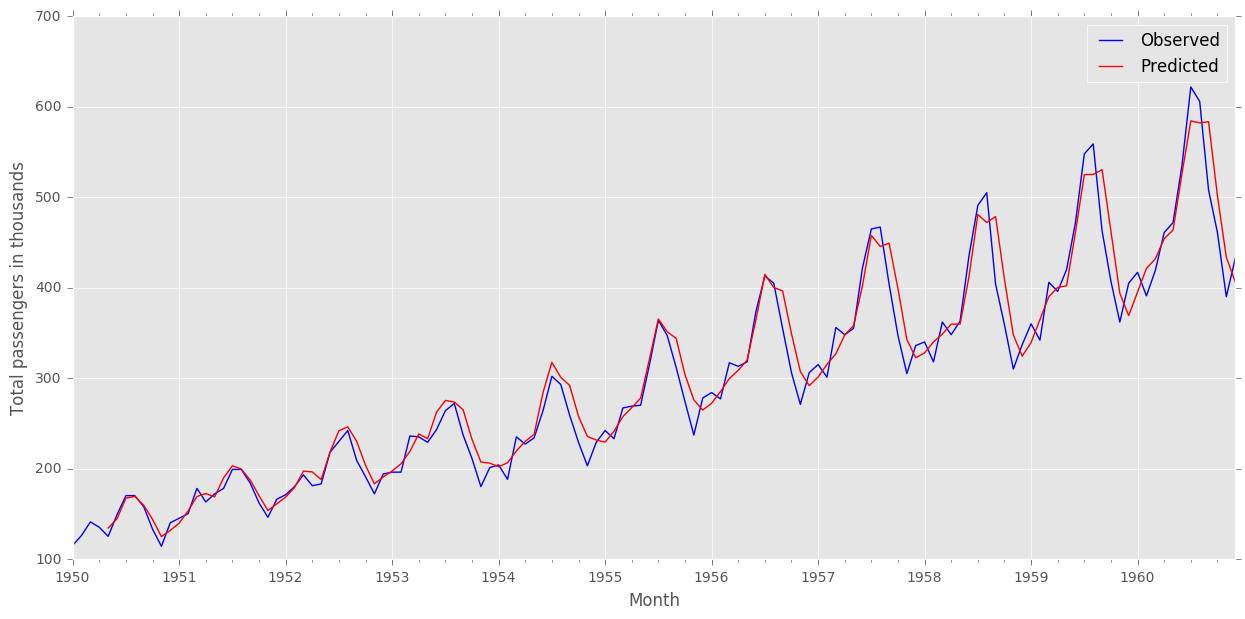

In [37]:
plot_model_prediction(df.fc)

## LSTM recurrent neural network

In [38]:
from sklearn import preprocessing

In [39]:
# to improve performance of LSTM network it is useful to rescale inputs
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

In [40]:
# scale diffrrencing values
df['scaled_diff'] = np.nan
df['scaled_diff'].ix[differencing_order:] = scaler.fit_transform(df.diff12.dropna().values.reshape(-1,1))[:,0]

In [41]:
look_back2 = 4
time_step = 1

dataset2 = df['scaled_diff'].dropna().values.astype('float32')
X2, y2 = create_dataset(dataset2, look_back2)
X2 = np.reshape(X2, (X2.shape[0], time_step, X2.shape[1]))

X2.shape, y2.shape

((128, 1, 4), (128,))

### Create Model

In [42]:
from keras.layers import LSTM

In [43]:
epochs = 100
batch_size = 10

seed = 7
np.random.seed(seed)

model2 = Sequential()
model2.add(LSTM(4, input_shape=(X2.shape[1], X2.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(X2, y2, nb_epoch=epochs, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/100
0s - loss: 0.2020
Epoch 2/100
0s - loss: 0.1706
Epoch 3/100
0s - loss: 0.1420
Epoch 4/100
0s - loss: 0.1161
Epoch 5/100
0s - loss: 0.0932
Epoch 6/100
0s - loss: 0.0736
Epoch 7/100
0s - loss: 0.0576
Epoch 8/100
0s - loss: 0.0450
Epoch 9/100
0s - loss: 0.0358
Epoch 10/100
0s - loss: 0.0294
Epoch 11/100
0s - loss: 0.0253
Epoch 12/100
0s - loss: 0.0229
Epoch 13/100
0s - loss: 0.0217
Epoch 14/100
0s - loss: 0.0211
Epoch 15/100
0s - loss: 0.0208
Epoch 16/100
0s - loss: 0.0207
Epoch 17/100
0s - loss: 0.0206
Epoch 18/100
0s - loss: 0.0206
Epoch 19/100
0s - loss: 0.0206
Epoch 20/100
0s - loss: 0.0205
Epoch 21/100
0s - loss: 0.0205
Epoch 22/100
0s - loss: 0.0205
Epoch 23/100
0s - loss: 0.0204
Epoch 24/100
0s - loss: 0.0204
Epoch 25/100
0s - loss: 0.0203
Epoch 26/100
0s - loss: 0.0203
Epoch 27/100
0s - loss: 0.0202
Epoch 28/100
0s - loss: 0.0202
Epoch 29/100
0s - loss: 0.0202
Epoch 30/100
0s - loss: 0.0201
Epoch 31/100
0s - loss: 0.0201
Epoch 32/100
0s - loss: 0.0200
Epoch 33/100
0s -

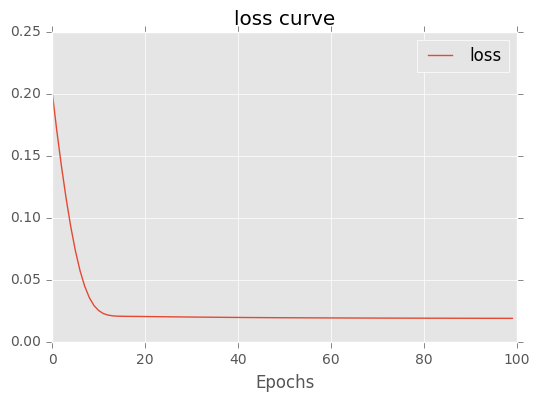

In [44]:
plt.plot(history2.history['loss'], label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('loss curve')
plt.show()

### Evaluate Model

In [45]:
# get differenced predictions
differenced_preds2 = scaler.inverse_transform(model2.predict(X2, batch_size=batch_size))

# get last observations for summarizing with differenced values
last_obs2 = df.total_passengers.ix[look_back2:differencing_order+look_back2].values

# rescale predictions
inverted_preds2 = inverse_differencing(differenced_preds2, last_obs2, differencing_order)

# save inverted predictions to dataframe
df['lstm'] = np.nan
df['lstm'].ix[differencing_order+look_back2:] = inverted_preds2[differencing_order:].reshape(-1,)

In [46]:
lstm_mse = mean_squared_error(
    df.total_passengers.ix[differencing_order+look_back2:].values, 
    df['lstm'].ix[differencing_order+look_back2:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(lstm_mse, np.sqrt(lstm_mse))

Model Score: 814.41 MSE (28.54 RMSE)


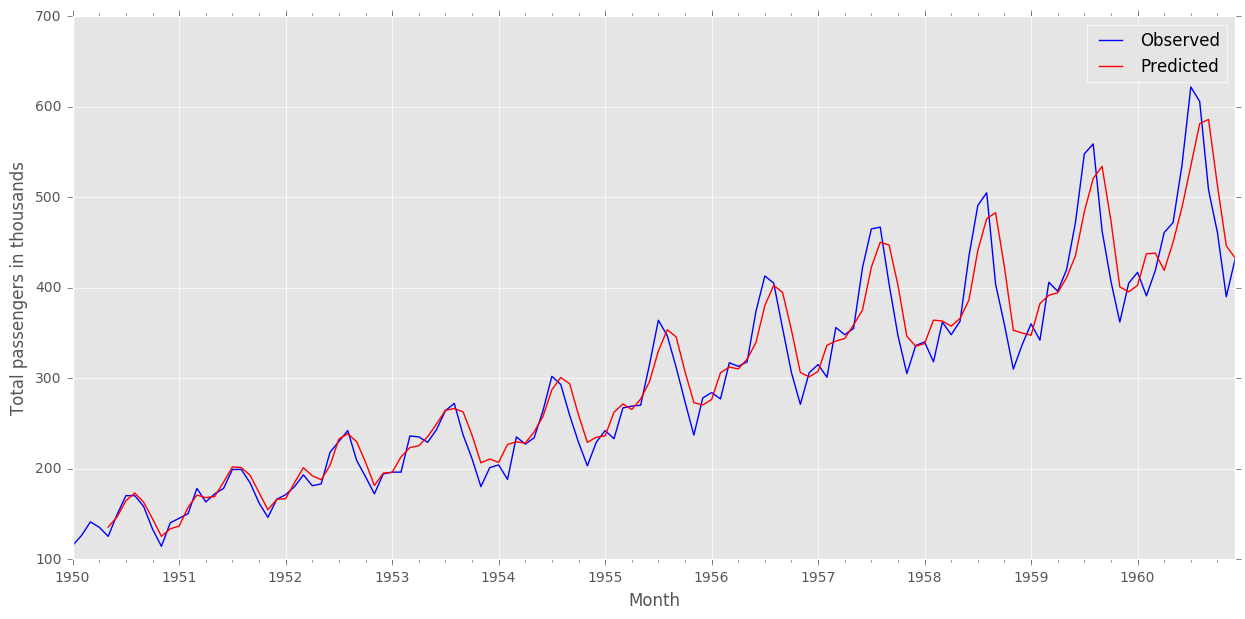

In [47]:
plot_model_prediction(df['lstm'])

## SVR

In [48]:
from sklearn import grid_search, svm, ensemble, neighbors

In [49]:
svr = svm.SVR().fit(X, y) # train model

Generate predictions, convert it from differencing scale to original scale and save it to dataframe

In [50]:
# rescale predictions
inverted_preds = inverse_differencing(svr.predict(X), last_obs, differencing_order)

# save rescaled predictions to df
df['svr'] = np.nan
df['svr'].ix[differencing_order+look_back2:] = inverted_preds[differencing_order:].reshape(-1,)

differenced_preds.shape, last_obs.shape, inverted_preds.shape

((128, 1), (12,), (140,))

In [51]:
# evaluate model
svr_mse = mean_squared_error(
    df.total_passengers.ix[differencing_order+look_back:].values, 
    inverted_preds[differencing_order:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(svr_mse, np.sqrt(svr_mse))

Model Score: 1215.72 MSE (34.87 RMSE)


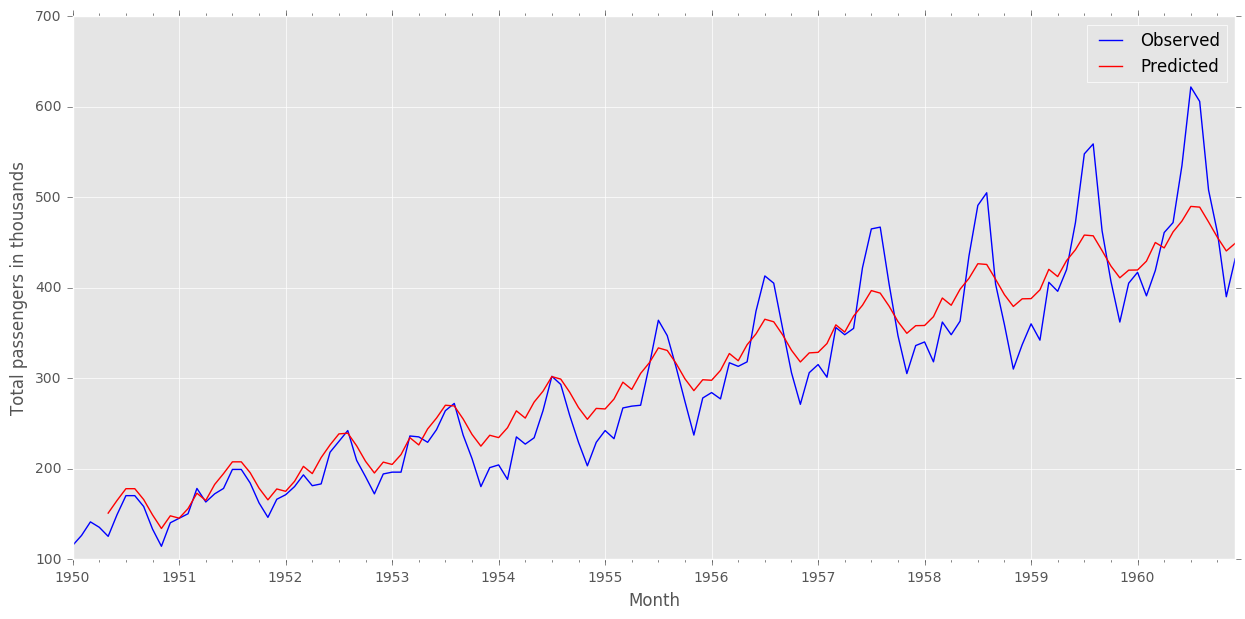

In [52]:
plot_model_prediction(df['svr'])

## KNN

In [53]:
# select optimal number of neighbors
parameters = {'n_neighbors':range(5,16)}
grid = grid_search.GridSearchCV(neighbors.KNeighborsRegressor(), parameters).fit(X, y)

In [54]:
print 'Best model params: {}'.format(grid.best_params_)

Best model params: {'n_neighbors': 14}


Generate predictions, convert it from differencing scale to original scale and save it to dataframe

In [55]:
# rescale predictions
inverted_preds = inverse_differencing(grid.predict(X), last_obs, differencing_order)

# save rescaled predictions to df
df['knn'] = np.nan
df['knn'].ix[differencing_order+look_back:] = inverted_preds[differencing_order:].reshape(-1,)

In [56]:
# evaluate model
knn_mse = mean_squared_error(
    df.total_passengers.ix[differencing_order+look_back:].values, 
    inverted_preds[differencing_order:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(knn_mse, np.sqrt(knn_mse))

Model Score: 513.30 MSE (22.66 RMSE)


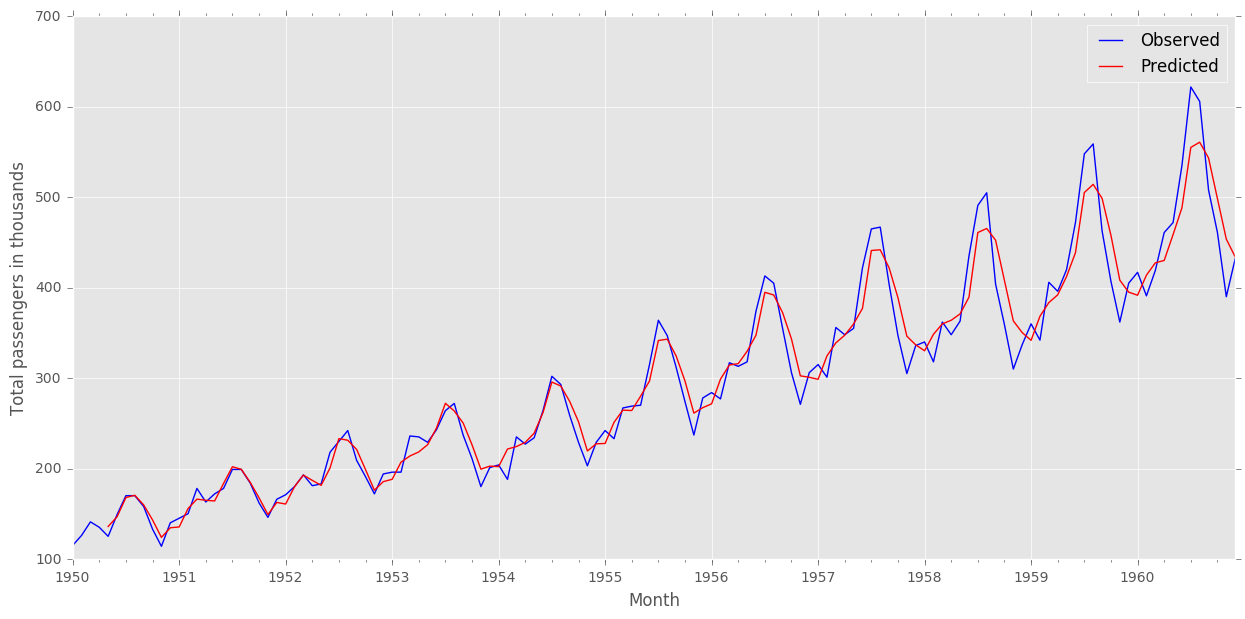

In [57]:
plot_model_prediction(df['knn'])

## Random forest

In [58]:
parameters = {'n_estimators':[5,10,15,20]}
grid = grid_search.GridSearchCV(ensemble.RandomForestRegressor(random_state=seed), parameters).fit(X, y)

In [59]:
print 'Best model params: {}'.format(grid.best_params_)

Best model params: {'n_estimators': 15}


Generate predictions, convert it from differencing scale to original scale and save it to dataframe

In [60]:
# rescale predictions
inverted_preds = inverse_differencing(grid.predict(X), last_obs, differencing_order)

# save rescaled predictions to df
df['tree'] = np.nan
df['tree'].ix[differencing_order+look_back2:] = inverted_preds[differencing_order:].reshape(-1,)

differenced_preds.shape, last_obs.shape, inverted_preds.shape

((128, 1), (12,), (140,))

In [61]:
# evaluate model
tree_mse = mean_squared_error(
    df.total_passengers.ix[differencing_order+look_back:].values, 
    inverted_preds[differencing_order:]
)
print 'Model Score: {0:.2f} MSE ({1:.2f} RMSE)'.format(tree_mse, np.sqrt(tree_mse))

Model Score: 97.62 MSE (9.88 RMSE)


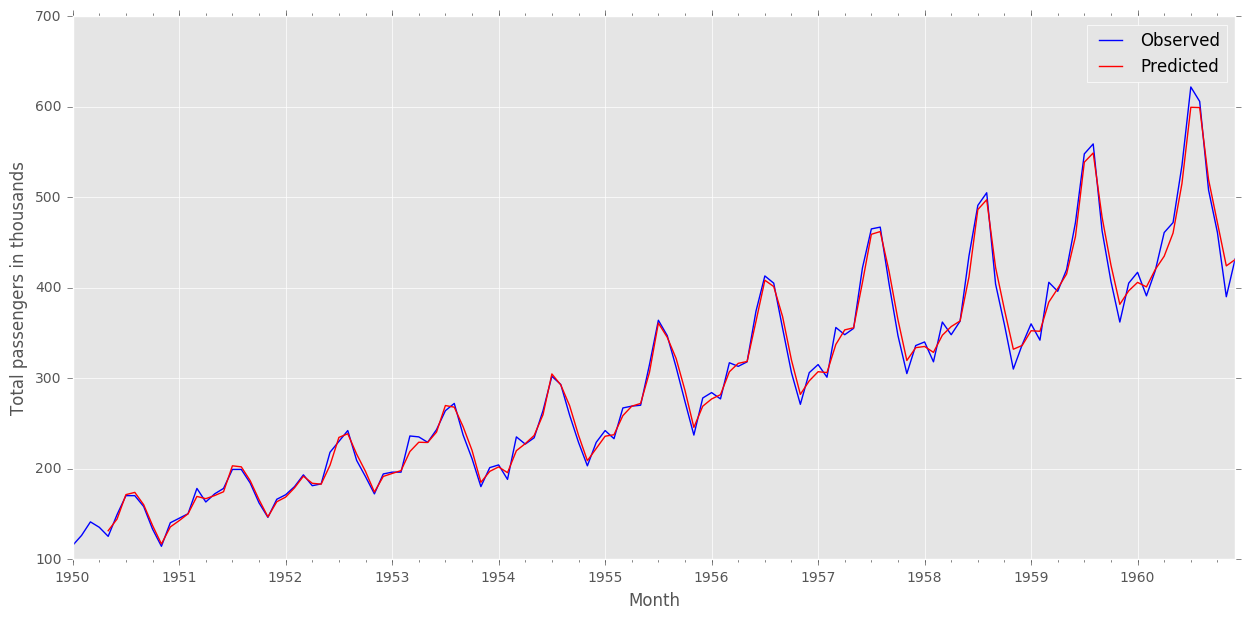

In [62]:
plot_model_prediction(df['tree'])

## Summary

In [63]:
scores_list = [
    ('ARMA', arma_mse, 'red'), 
    ('fully-connected NN', fc_mse, 'cyan'), 
    ('LSTM NN', lstm_mse, 'magenta'),
    ('svr', svr_mse, 'yellow'), 
    ('knn', knn_mse, 'blue'), 
    ('random forest', tree_mse, 'green'),     
]

# sort model names and scores
colors = [i[2] for i in sorted(scores_list, key=lambda x: x[1])]
models = [i[0] for i in sorted(scores_list, key=lambda x: x[1])]
scores = [i[1] ** 0.5 for i in sorted(scores_list, key=lambda x: x[1])]

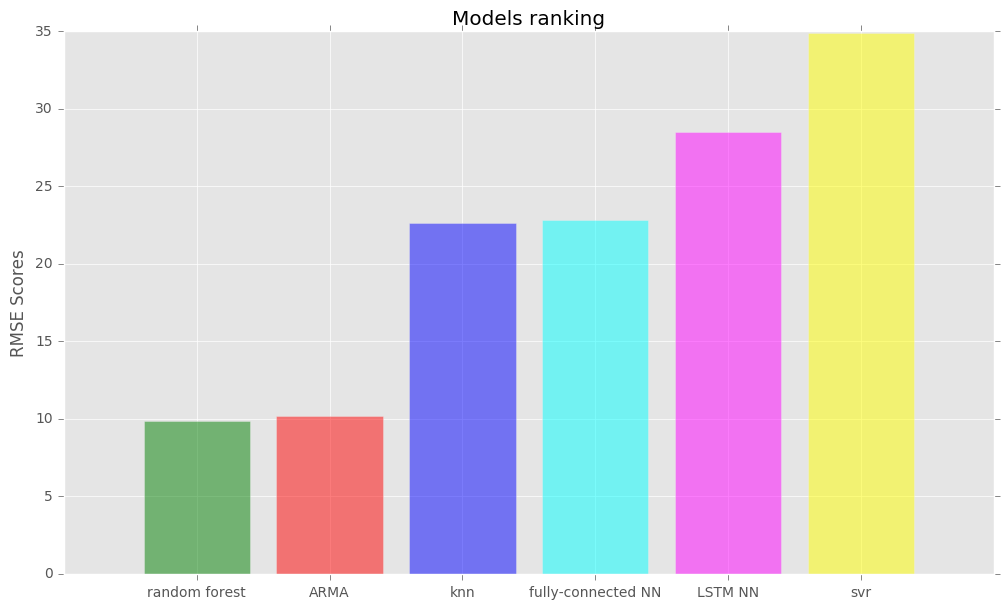

In [65]:
f, ax = plt.subplots(figsize=(12,7))

y = range(len(models))
ax.bar(y, scores, align='center', alpha=0.5, color=colors)
ax.set_ylabel('RMSE Scores')
ax.set_xticks(y)
ax.set_xticklabels(models)
ax.set_title('Models ranking')

plt.show()